This notebook will build my final submission for the coursera project.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Data fields description:
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date - date in format dd/mm/yyyy
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from calendar import monthrange

from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

Load the training data and create some new features based on the date field.

In [2]:
data_df = pd.read_csv('./data/sales_train.csv')
print('Data rows:  {:,}'.format(len(data_df)))

data_df['date'] = pd.to_datetime(data_df['date'], format='%d.%m.%Y')

# Let's break up the date field into constituent pieces.
data_df['date (year)'] = data_df['date'].dt.year
data_df['date (month)'] = data_df['date'].dt.month
data_df['date (days in month)'] = data_df['date'].apply(lambda x: monthrange(x.year, x.month)[1])

data_df.head(2).transpose()

Data rows:  2,935,849


,0,1
date,2013-01-02 00:00:00,2013-01-03 00:00:00
date_block_num,0,0
shop_id,59,25
item_id,22154,2552
item_price,999,899
item_cnt_day,1,1
date (year),2013,2013
date (month),1,1
date (days in month),31,31


Let's inspect the counts and prices looking for outliers.

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64
Prices over 50k?  3


(array([2.935632e+06, 2.160000e+02, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-1.000000e+00,  3.079710e+04,  6.159520e+04,  9.239330e+04,
         1.231914e+05,  1.539895e+05,  1.847876e+05,  2.155857e+05,
         2.463838e+05,  2.771819e+05,  3.079800e+05]),
 <a list of 10 Patch objects>)

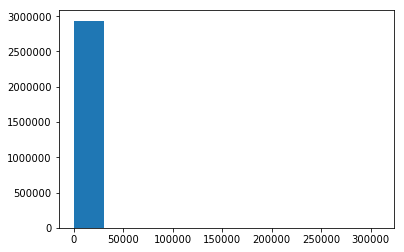

In [3]:
print(data_df['item_price'].describe())
print('Prices over 50k?  {:,}'.format(len(data_df[data_df['item_price'] > 50000])))

plt.hist(data_df['item_price'])

Let's remove any prices greater than 50,000.

(array([2.900052e+06, 1.444500e+04, 1.069600e+04, 3.691000e+03,
        4.228000e+03, 2.283000e+03, 4.070000e+02, 3.300000e+01,
        1.000000e+01, 1.000000e+00]),
 array([-1.00000e+00,  4.97730e+03,  9.95560e+03,  1.49339e+04,
         1.99122e+04,  2.48905e+04,  2.98688e+04,  3.48471e+04,
         3.98254e+04,  4.48037e+04,  4.97820e+04]),
 <a list of 10 Patch objects>)

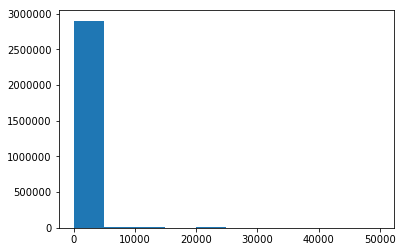

In [4]:
data_df = data_df[data_df['item_price'] < 50000]

plt.hist(data_df['item_price'])

count    2.935846e+06
mean     1.242641e+00
std      2.618836e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64
Counts over 1000?  1


(array([2.935807e+06, 2.400000e+01, 1.100000e+01, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([ -22. ,  197.1,  416.2,  635.3,  854.4, 1073.5, 1292.6, 1511.7,
        1730.8, 1949.9, 2169. ]),
 <a list of 10 Patch objects>)

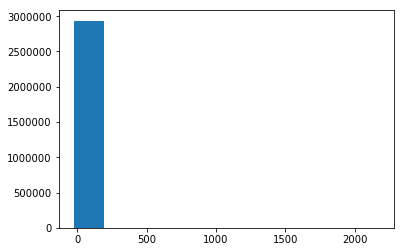

In [5]:
print(data_df['item_cnt_day'].describe())
print('Counts over 1000?  {:,}'.format(len(data_df[data_df['item_cnt_day'] > 1000])))

plt.hist(data_df['item_cnt_day'])

Let's remove the one count that is greater than 1000.

(array([2.935627e+06, 1.770000e+02, 1.600000e+01, 7.000000e+00,
        5.000000e+00, 9.000000e+00, 3.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([ -22. ,   80.2,  182.4,  284.6,  386.8,  489. ,  591.2,  693.4,
         795.6,  897.8, 1000. ]),
 <a list of 10 Patch objects>)

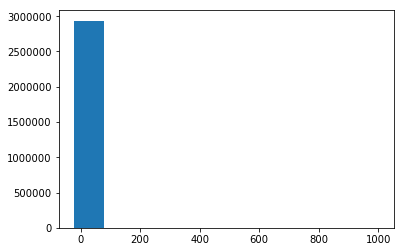

In [6]:
data_df = data_df[data_df['item_cnt_day'] < 1001]

plt.hist(data_df['item_cnt_day'])

In [7]:
item_categories_df = pd.read_csv('./data/items.csv')
print('Item categories:  {:,}'.format(len(item_categories_df)))

item_categories_df['item_id'] = item_categories_df['item_id'].astype(int)
item_categories_df['item_category_id'] = item_categories_df['item_category_id'].astype(int)

item_categories_df.head(3)

Item categories:  22,170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [8]:
shops_df = pd.read_csv('./data/shops.csv')
print('Shop rows:  {:,}'.format(len(shops_df)))

shops_df['shop_id'] = shops_df['shop_id'].astype(int)

shops_df.head(3)

Shop rows:  60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


Since we are trying to predict a future month, we need to convert the data into a monthly format.

In [9]:
monthly_df = data_df.groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()
monthly_df.columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']

Load the test data and merge into the big dataset.

In [10]:
test_df = pd.read_csv('./data/test.csv')
print('Test rows:  {:,}'.format(len(test_df)))

# Fixed values.
test_df['date_block_num'] = 34
test_df['date (year)'] = 2015
test_df['date (month)'] = 11
test_df['date (days in month)'] = 30

# Update the prices with the latest month's prices.
last_month_df = data_df[data_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_price']]

test_df = test_df.merge(last_month_df, on=['shop_id', 'item_id'], how='left')
test_df = test_df.drop_duplicates('ID', keep='first')

print('Test rows (after merge):  {:,}'.format(len(test_df)))

test_df[test_df['item_price'] > 0].head(2).T

Test rows:  214,200
Test rows (after merge):  214,200


,2,5
ID,2.0,5.0
shop_id,5.0,5.0
item_id,5233.0,5039.0
date_block_num,34.0,34.0
date (year),2015.0,2015.0
date (month),11.0,11.0
date (days in month),30.0,30.0
item_price,1199.0,1499.0


In [11]:
data_df = pd.concat([data_df, test_df], ignore_index=True, sort=False)
data_df = data_df.fillna(0)

print('Rows:  {:,}'.format(len(data_df)))

Rows:  3,150,045


Merge the monthly results back into the training dataframe.

In [12]:
print('Training before merge:  {:,}'.format(len(data_df)))

data_df = data_df.merge(monthly_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
data_df['item_cnt_month'] = data_df['item_cnt_month'].fillna(0)

data_df = data_df.merge(item_categories_df[['item_id', 'item_category_id']], on='item_id', how='left')

data_df['date_block_num'] = data_df['date_block_num'].astype('int')
data_df['shop_id'] = data_df['shop_id'].astype('int')
data_df['item_id'] = data_df['item_id'].astype('int')
data_df['item_category_id'] = data_df['item_category_id'].astype('int')
data_df['date (year)'] = data_df['date (year)'].astype('int')
data_df['date (month)'] = data_df['date (month)'].astype('int')
data_df['date (days in month)'] = data_df['date (days in month)'].astype('int')

print('Training after merge:  {:,}'.format(len(data_df)))

# Drop the daily columns that aren't needed.
data_df = data_df.drop(['date', 'item_cnt_day'], axis=1)

data_df.head(2).T

Training before merge:  3,150,045
Training after merge:  3,150,045


,0,1
date_block_num,0.0,0.0
shop_id,59.0,25.0
item_id,22154.0,2552.0
item_price,999.0,899.0
date (year),2013.0,2013.0
date (month),1.0,1.0
date (days in month),31.0,31.0
ID,0.0,0.0
item_cnt_month,1.0,0.0
item_category_id,37.0,58.0


In [13]:
data_df['item_cnt_month'].describe()

count    3.150045e+06
mean     6.884522e+00
std      2.882225e+01
min     -2.200000e+01
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

Counts of a negative number represent "returns".  Thus, let's take these values out.

In [14]:
print('Rows before returns removed:  {:,}'.format(len(data_df)))

data_df = data_df[data_df['item_cnt_month'] >= 0]

print('Rows after returns removed:  {:,}'.format(len(data_df)))

Rows before returns removed:  3,150,045
Rows after returns removed:  3,149,076


In [15]:
data_df['item_cnt_month'].describe()

count    3.149076e+06
mean     6.887001e+00
std      2.882633e+01
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

In [16]:
data_df['item_price'].describe()

count    3.149076e+06
mean     8.405259e+02
std      1.690195e+03
min     -1.000000e+00
25%      1.990000e+02
50%      3.990000e+02
75%      8.995000e+02
max      4.978200e+04
Name: item_price, dtype: float64

Some item's are priced negatively.  Instead of zero, let's use the median here.

In [17]:
price_median = np.median(data_df['item_price'])
print('Price median:  {:}'.format(price_median))

data_df['item_price'] = data_df['item_price'].apply(lambda x: x if x >= 0 else price_median)

Price median:  399.0


In [18]:
data_df['item_price'].describe()

count    3.149076e+06
mean     8.405260e+02
std      1.690195e+03
min      0.000000e+00
25%      1.990000e+02
50%      3.990000e+02
75%      8.995000e+02
max      4.978200e+04
Name: item_price, dtype: float64

Create a revenue data feature.

In [19]:
data_df['revenue_month'] = data_df['item_price'] * data_df['item_cnt_month']

Add a mean encoded feature.

In [20]:
grouped_df = data_df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']}).reset_index()
grouped_df.columns = ['date_block_num', 'item_cnt_mef']

print(grouped_df.head(3))

data_df = pd.merge(data_df, grouped_df, on=['date_block_num'], how='left')

   date_block_num  item_cnt_mef
0               0      5.238760
1               1      5.419628
2               2      6.605059


Now, let's add some lagged features.

In [21]:
month_lags = [1, 2, 3, 6, 12]
col_lags = ['item_cnt_month', 'item_price', 'revenue_month', 'item_cnt_mef']

for col in col_lags:
    for month in month_lags:
        new_col = '{:} (-{:})'.format(col, month)
        data_df[new_col] = data_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])[col].shift(month)
        data_df[new_col] = data_df[new_col].fillna(0.0)
    
# Drop columns that we cannot use in training.
data_df = data_df.drop(['revenue_month', 'item_cnt_mef'], axis=1)
                       
data_df.head(2).T

,0,1
date_block_num,0.0,0.00000
shop_id,59.0,25.00000
item_id,22154.0,2552.00000
item_price,999.0,899.00000
date (year),2013.0,2013.00000
date (month),1.0,1.00000
date (days in month),31.0,31.00000
ID,0.0,0.00000
item_cnt_month,1.0,0.00000
item_category_id,37.0,58.00000


In [22]:
data_df.describe()

,date_block_num,shop_id,item_id,item_price,date (year),date (month),date (days in month),ID,item_cnt_month,item_category_id,...,revenue_month (-1),revenue_month (-2),revenue_month (-3),revenue_month (-6),revenue_month (-12),item_cnt_mef (-1),item_cnt_mef (-2),item_cnt_mef (-3),item_cnt_mef (-6),item_cnt_mef (-12)
count,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,...,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06,3.149076e+06
mean,1.589172e+01,3.291088e+01,1.025335e+04,8.405260e+02,2.013860e+03,6.571189e+00,3.039884e+01,7.284903e+03,6.887001e+00,4.043224e+01,...,6.158957e+03,6.001051e+03,5.842839e+03,5.399491e+03,4.653873e+03,6.165729e+00,5.429309e+00,4.870006e+00,3.738651e+00,2.532078e+00
std,1.032888e+01,1.632434e+01,6.322862e+03,1.690195e+03,8.032610e-01,3.617427e+00,8.686052e-01,3.141993e+04,2.882633e+01,1.714804e+01,...,4.133641e+04,4.123074e+04,4.108327e+04,4.048315e+04,3.893006e+04,3.172836e+00,3.589157e+00,3.780284e+00,3.901715e+00,3.657612e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.510000e+03,1.990000e+02,2.013000e+03,3.000000e+00,3.000000e+01,0.000000e+00,1.000000e+00,2.900000e+01,...,1.993400e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.265959e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,3.100000e+01,9.461000e+03,3.990000e+02,2.014000e+03,7.000000e+00,3.100000e+01,0.000000e+00,2.000000e+00,4.000000e+01,...,8.970000e+02,7.490000e+02,5.980000e+02,9.900000e+01,0.000000e+00,6.605059e+00,6.498355e+00,6.041723e+00,4.832291e+00,0.000000e+00
75%,2.400000e+01,4.700000e+01,1.572900e+04,8.995000e+02,2.015000e+03,1.000000e+01,3.100000e+01,0.000000e+00,5.000000e+00,5.500000e+01,...,3.290000e+03,3.184000e+03,2.997000e+03,2.398000e+03,1.199000e+03,8.404300e+00,7.856967e+00,7.627376e+00,7.104757e+00,6.353680e+00
max,3.400000e+01,5.900000e+01,2.216900e+04,4.978200e+04,2.015000e+03,1.200000e+01,3.100000e+01,2.141990e+05,1.644000e+03,8.300000e+01,...,7.809210e+06,7.809210e+06,7.809210e+06,7.809210e+06,7.809210e+06,1.173553e+01,1.173553e+01,1.173553e+01,1.173553e+01,1.173553e+01


In [23]:
np.max(data_df['date_block_num'])

34

We will use date_block_num == 33 for the test set, date_block_num == 34 for the prediction set, and all other rows as training.  
Since we are using 12 month's of lagged data, discard any training rows between 0 and 11.

In [24]:
train_df = data_df[(data_df['date_block_num'] > 11) & (data_df['date_block_num'] < 33)]
test_df = data_df[data_df['date_block_num'] == 33]
pred_df = data_df[data_df['date_block_num'] == 34]

print('  Training rows:  {:,}'.format(len(train_df)))
print('   Testing rows:  {:,}'.format(len(test_df)))
print('Prediction rows:  {:,}'.format(len(pred_df)))

  Training rows:  1,614,230
   Testing rows:  53,503
Prediction rows:  214,200


In [25]:
X_train = train_df.drop(['ID', 'item_cnt_month'], axis=1)
y_train = train_df['item_cnt_month']

X_test = test_df.drop(['ID', 'item_cnt_month'], axis=1)
y_test = test_df['item_cnt_month']

X_pred = pred_df.drop(['ID', 'item_cnt_month'], axis=1)

Now train the regressor.

In [26]:
xgb = XGBRegressor(seed=0, 
                   n_estimators=1000,
                   max_depth=10,
                   min_child_weight=500,
                   eta=0.3,
                   subsample=0.8
)

xgb.fit(X_train, 
        y_train, 
        eval_metric='rmse',  
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=True, 
        early_stopping_rounds=10)

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:51:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29.5723	validation_1-rmse:21.4098
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:26.8261	validation_1-rmse:19.3615
[2]	validation_0-rmse:24.4013	validation_1-rmse:17.4367
[3]	validation_0-rmse:22.2291	validation_1-rmse:15.8248
[4]	validation_0-rmse:20.28	validation_1-rmse:14.3383
[5]	validation_0-rmse:18.5507	validation_1-rmse:12.9237
[6]	validation_0-rmse:17.0243	validation_1-rmse:11.7265
[7]	validation_0-rmse:15.6991	validation_1-rmse:10.672
[8]	validation_0-rmse:14.5078	validation_1-rmse:9.73422
[9]	validation_0-rmse:13.4565	validation_1-rmse:8.89981
[10]	validation_0-rmse:12.5523	validation_1-rmse:8.17811
[11]	validation_0-rmse:11.7758	validation_1-rmse:7.54679
[12]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=500, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=0.8, verbosity=1)

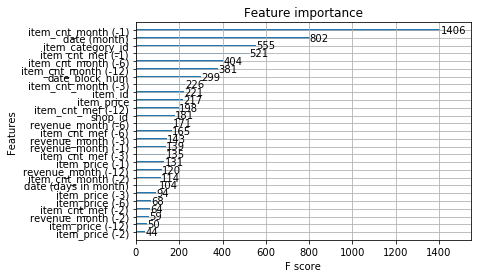

In [27]:
plot_importance(xgb)

In [28]:
pred_df['item_cnt_month'] = xgb.predict(X_pred).clip(0, 20)

pred_df['ID'] = pred_df['ID'].astype(int)

pred_df[['ID', 'item_cnt_month']].to_csv('submissions/final_submission.csv', index=False)

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
bagged_df = pd.read_csv('submissions/submission-Oct-2015.csv')
bagged_df.head(5)

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


In [40]:
pred_df[['ID', 'item_cnt_month']].head(5)

,ID,item_cnt_month
2934876,0,3.070728
2934877,1,3.165295
2934878,2,1.442291
2934879,3,2.844170
2934880,4,6.340352


In [41]:
bagged_df = bagged_df.merge(pred_df[['ID', 'item_cnt_month']], on='ID')
bagged_df.head(5)

,ID,item_cnt_month_x,item_cnt_month_y
0,0,0.0,3.070728
1,1,0.0,3.165295
2,2,1.0,1.442291
3,3,0.0,2.844170
4,4,0.0,6.340352


In [42]:
bagged_df.columns = ['ID', 'item_cnt_month (oct)', 'item_cnt_month (ML)']

In [37]:
bagged_df.head(5)

,ID,item_cnt_month (oct),item_cnt_month (ML)
0,0,0.0,3.070728
1,1,0.0,3.165295
2,2,1.0,1.442291
3,3,0.0,2.844170
4,4,0.0,6.340352


In [46]:
def get_bagged_value(row):
    return 0 if row['item_cnt_month (oct)'] == 0.0 else (row['item_cnt_month (oct)'] + row['item_cnt_month (ML)']) / 2.0

bagged_df['item_cnt_month'] = bagged_df.apply(lambda row: get_bagged_value(row), axis=1)

In [47]:
bagged_df.head(5)

,ID,item_cnt_month (oct),item_cnt_month (ML),bagged,item_cnt_month
0,0,0.0,3.070728,0.000000,0.000000
1,1,0.0,3.165295,0.000000,0.000000
2,2,1.0,1.442291,1.221146,1.221146
3,3,0.0,2.844170,0.000000,0.000000
4,4,0.0,6.340352,0.000000,0.000000


In [49]:
bagged_df[['ID', 'item_cnt_month']].to_csv('./submissions/bagged.csv', index=False)

In [56]:
bagged_df['item_cnt_month'] = (bagged_df['item_cnt_month (oct)'] + bagged_df['item_cnt_month (ML)']) / 2

bagged_df.head(5)

,ID,item_cnt_month (oct),item_cnt_month (ML),bagged,item_cnt_month
0,0,0.0,3.070728,0.000000,1.535364
1,1,0.0,3.165295,0.000000,1.582648
2,2,1.0,1.442291,1.221146,1.221146
3,3,0.0,2.844170,0.000000,1.422085
4,4,0.0,6.340352,0.000000,3.170176


In [60]:
bagged_df[['ID', 'item_cnt_month']].to_csv('C:/temp/bagged3.csv', index=False)

In [61]:
print(np.max(bagged_df['item_cnt_month (oct)']))

20.0
